# Analisis de Datos en Física Moderna
## Pietro Vischia (Universidad de Oviedo and ICTEA), pietro.vischia@cern.ch

The core of this tutorial comes from https://github.com/vischia/data_science_school_igfae2024 (Pietro Vischia (pietro.vischia@cern.ch)).

In [3]:
import torch
import torch
import torch.nn as nn  
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
import torchvision
from tqdm import tqdm

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load the MNIST dataset and inspect it.
This dataset is handily hosted in the package `torchvision`.

You can also apply a series of transformations, e.g. the following if you want to standardize automatically the dataset to the global mean and variance. Suggestion: start by not standardizing.

NOTE: the standardization transform is called `normalize` in the package `torchvision`.

```
transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
```

Another transform it is usually done is to divide values in the image by `255` to have them before 0 and 1.

In [4]:
batch_size = 64 # Or whichever value you may see fit
# You can also explore whether dense and convolutional networks work best with different batch sizes

# Load Data
train_dataset = torchvision.datasets.MNIST(root='dataset/', train=True, transform=torchvision.transforms.ToTensor(),  
                                           #target_transform = torchvision.transforms.Compose([
                                           # lambda x:torch.LongTensor([x]), # or just torch.tensor
                                           # lambda x:F.one_hot(x,10)]),
                                            download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='dataset/', train=False, transform=torchvision.transforms.ToTensor(), 
#target_transform = torchvision.transforms.Compose([
#                                 lambda x:torch.LongTensor([x]), # or just torch.tensor
#                                 lambda x:F.one_hot(x,10)]),
                                          download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

We can inspect the dataset.

Suggestion: inspect the dataset after trying out different transforms.

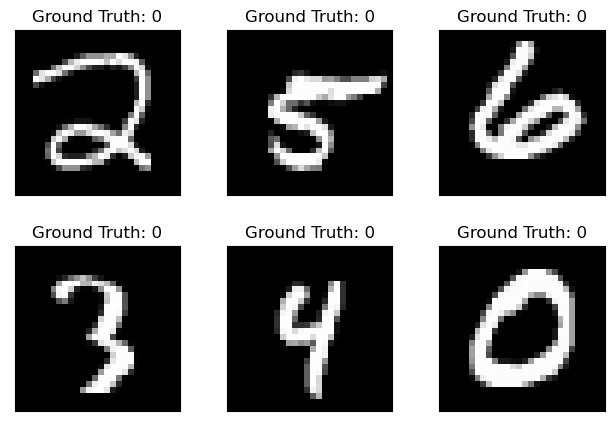

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(torch.argmax(example_targets[i])))
  plt.xticks([])
  plt.yticks([])


Define a fully connected neural network model


In [6]:
class DenseNetwork(nn.Module):
    def __init__(self, input_size, num_classes, device=torch.device("cpu")):
        super().__init__()
        self.dense = nn.Sequential(
            # here put layers. Some choices you have seen are:
            #     nn.Dropout(p=0.4),
            #     nn.Linear(input_size, 128),
            #     nn.BatchNorm1d(128),
            #     nn.ReLU(),
            #     nn.sigmoid(),
            #     nn.Softmax(dim=1)
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )
        self.dense.to(device)

    def forward(self, x):
        x = self.dense(x)
        return x


In [17]:
input_size = 28*28*1 # You have to figure this out
num_classes = 10 # You have to figure this out
learning_rate = 0.001 # You have to figure this out
num_epochs = 3 # You have to figure this out

# Initialize Network
model = DenseNetwork(input_size=input_size, num_classes=num_classes).to(device)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad)

total_pars, trainable_pars = count_parameters(model)
print("I have ", total_pars, "parameter and ", trainable_pars, " trainable parameters")
    
print("len", len([i for i in model.parameters()]))
# Loss and Optimizer
loss_fn = torch.nn.CrossEntropyLoss() # You have to figure this out
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

I have  109386 parameter and  109386  trainable parameters
len 6


The transformation `torchvision.transforms.Normalize` does what we call *Standardizatio*, that is it rescales data to have the same mean and variance. Here, the two hardcoded values are the mean and variance of the whole MNIST data set.


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, cnn, device):
    losses=[] # Track the loss function
    accs= [] # Track accuracies
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
    #for batch, (X, y) in tqdm(enumerate(dataloader, 0), unit="batch", total=len(dataloader)):
    #for (X,y) in tqdm(dataloader):
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        if not cnn:
            X = X.reshape(X.shape[0], -1)
        pred = model(X)
        
        #print("Y", y)
        #pred= pred.reshape([pred.shape[0], 1, num_classes])
        #print(torch.argmax(pred, dim=2), torch.argmax(y, dim=2))
        loss = loss_fn(pred,y)
        #print(loss)
        losses.append(loss.detach().cpu())
        acc = (torch.argmax(pred, 1) == y).float().mean()
        accs.append(acc.detach().cpu())
        loss.backward()
        optimizer.step()

    return np.mean(losses), np.mean(accs)

def test_loop(dataloader, model, loss_fn, cnn, device):

    losses=[] # Track the loss function
    accs = [] # Track accuracies
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        #for batch, (X, y) in tqdm(enumerate(dataloader, 0), unit="batch", total=len(dataloader)):
        for (X,y) in tqdm(dataloader):
            if not cnn:
                X = X.reshape(X.shape[0], -1)
            pred = model(X)
            #pred= pred.reshape([pred.shape[0], 1, num_classes])
            loss = loss_fn(pred, y)
            acc = (torch.argmax(pred, 1) == y).float().mean()
            losses.append(loss)
            accs.append(acc.detach().cpu())
            test_loss += loss
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return np.mean(losses), np.mean(accs)


In [ ]:
train_losses=[]
test_losses=[]
train_accuracies=[]
test_accuracies=[]
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer, scheduler, False, device)
    test_loss, test_accuracy = test_loop(test_loader, model, loss_fn, False, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", scheduler.get_last_lr())
print("Done!")

Now let's create a convolutional network

Relevant parameters:

- `in_channels`: number of input channels. For black-and-white images, this is 1. RGB images have 3.
- `num_classes`: how many digits do we want to recognize?

The first `Conv2d` layer has 8 kernels of size 3x3, i.e. splits the image in eight separate channels each with its own convolution operation. Padding ensures the size of the image remains the same.
The second `Conv2d` layer has 16 filters, also with 3x3 kernel.

The `MaxPool2d` layer has a 2x2 kernel and a stride of 2. This does averaging and dimensional reduction, downsampling the image by a factor 2 in each dimension (from 28x28 to 14x14 the first time we apply it, and from 14x14 to 7x7 the second time).

The output of the second `Conv2d` layer will therefore a 16-channel image where each channel is 7x7. We flatten it to a one-dimensional vector per image to feed it to a dense layer that does classification.


In [ ]:
class ConvNetwork(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(ConvNetwork, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Flatten(),
            nn.Linear(16*7*7, num_classes)
            # Another activation function here? Or not?
        )
    def forward(self, x):
        x = self.conv(x)
        return x
    
    


Now we change the input parameters accordingly (in general they won't be the same as the dense network) and instatiate the convolutional network

In [ ]:
in_channels = 1 # You have to figure this out
num_classes = 10 # You have to figure this out
learning_rate = 0.01 # You have to figure this out
num_epochs = 5 # You have to figure this out

# Initialize Network
model = ConvNetwork(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and Optimizer
criterion = torch.nn.CrossEntropyLoss() # You have to figure this out
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Now you can train again. The training and test look will be the same, but you will need to change the names in the loop below to save the training data for the convolutional network


In [ ]:
conv_train_losses=[]
conv_test_losses=[]
conv_train_accuracies=[]
conv_test_accuracies=[]
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    conv_train_loss, conv_train_accuracy = train_loop(train_loader, model, loss_fn, optimizer, scheduler, True, device)
    conv_test_loss, conv_test_accuracy = test_loop(test_loader, model, loss_fn, True, device)
    conv_train_losses.append(conv_train_loss)
    conv_train_accuracies.append(conv_train_accuracy)
    conv_test_losses.append(conv_test_loss)
    conv_test_accuracies.append(conv_test_accuracy)
    print("Avg train loss", conv_train_loss, ", Avg test loss", conv_test_loss, "Current learning rate", scheduler.get_last_lr())
print("Done!")

Now you can for instance plot the losses for both networks (train and test data sets), build the confusion matrix for the two networks, check how many trainable parameters (remember `torchinfo.summary(model)`...) are needed for each network type to give you a certain performance, and other useful stuff for the report